In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import zipfile
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from datetime import datetime as dt
import time
import pickle

import matplotlib.pylab as plt
%matplotlib inline
 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/Users/a90181/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/a90181/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [9]:
zf = zipfile.ZipFile('haihu_18.csv.zip') 
raw = pd.read_csv(zf.open('haihu_18.csv'), nrows=100000)
df = raw.copy()
# df['ID'] = range(1, len(df) + 1)
df.head()

,date,floorPrice,site,user,advertiserId,isClick
0,2018-05-19 19:56:36,110.93,106482,b92016a770e5359e,adv_18,0
1,2018-05-19 10:05:06,28.35,103978,5388808965633918,adv_03,0
2,2018-05-17 16:36:56,44.64,103716,550d0ca7ba8d3cac,adv_18,0
3,2018-05-18 01:34:27,75.81,108463,26fcffa89ea03c53,adv_14,0
4,2018-05-19 11:54:00,126.32,111345,812802100c7c31e8,adv_16,0


In [10]:
# one_hot = pd.get_dummies(df['user'] )
# df.drop('user',axis=1)
# df = df.join(one_hot)

# one_hot = pd.get_dummies(df['advertiserId'] )
# df.drop('advertiserId',axis=1)
# df = df.join(one_hot)

# pre processing
# date -> day, tag, time
# df['isClick'] = df['isClick'].astype(int)
df['user'] = df['user'].map(lambda uid: hash(uid))
df['advertiserId'] = df['advertiserId'].map(lambda adId: int(float(adId.split("_")[1])))
# df['label'] = df['floorPrice'].map(lambda f: f > 250)
# df["day"]= df['date'].map(lambda date: dt.strptime(date, '%Y-%m-%d %H:%M:%S').day)
# df["hour"]= df['date'].map(lambda date: dt.strptime(date, '%Y-%m-%d %H:%M:%S').hour)
# df["timestamp"]=df['date'].map(lambda date: time.mktime(dt.strptime(date, '%Y-%m-%d %H:%M:%S').timetuple()))


# def test (f):
#     fDf = df[df.floorPrice == f]
#     return fDf.isClick.sum()/len(fDf)

# df['floorPrice'] = df['floorPrice'].map(lambda f: test(f))

# df.assign(session=pd.cut(df["hour"],[-1,6,12,18,24],labels=[1,2,3,4])) # 'Night','Morning','Afternoon','Evening'
# df.assign(floorPrice=pd.cut(df["floorPrice"],list(range(-1,100000,1000)),labels=list(range(len(list(range(-1,100000,1000)))-1))))

In [11]:
#学習用データとテスト用データの作成
msk = np.random.rand(len(df)) < 0.8 #乱数を発生させて0.8よりも小さいデータを選ぶ
train = df[msk]
test = df[~msk]

target="isClick"

train.shape, test.shape

((79963, 6), (20037, 6))

/Users/a90181/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.8722
AUC Score (Train): 0.840945
AUC Score (Test): 0.835394


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x1a12a207b8>>
Traceback (most recent call last):
  File "/Users/a90181/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
/Users/a90181/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


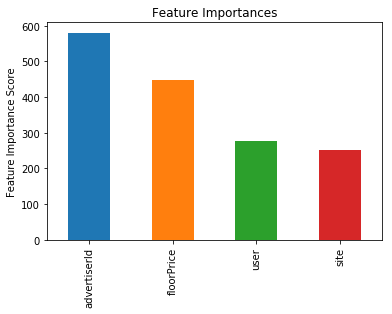

In [14]:
#テスト結果を格納するデータフレームの生成
# test_results = pd.DataFrame(data=test.ID)

#関数の定義
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['auc'], early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric=['auc'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
    # Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    #results = test_results.merge(dtest[['ID','predprob']], on='ID')
    print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest[target], dtest['predprob']))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


predictors = [x for x in train.columns if x not in [target, "date"]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=3,
        min_child_weight=5,
        gamma=0.4,
        subsample=0.85,
        colsample_bytree=0.75,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        reg_alpha=1,
        seed=27)

modelfit(xgb1, train, test, predictors)

In [164]:
pd.DataFrame(data)

matrix([[ 2.83500e+01,  1.03978e+05, -1.08162e+15,  3.00000e+00]])

In [15]:
# data =  [[28.35,  103978, -1.081620e+15, 3]]
# feature_names = ['floorPrice', 'site', 'user', 'advertiserId']
# dtest1 = xgb.DMatrix(pd.DataFrame(data), feature_names=feature_names)

from sklearn.externals import joblib
joblib.dump(xgb1,'model_all.pkl')
loaded_model = joblib.load('model.pkl')

# pickle.dump(xgb1, open("model.pkl", "wb"))
# loaded_model = pickle.load(open("model.pkl", "rb"))

data = pd.DataFrame([[28.35,  103978, -1.081620e+15, 3]], columns=['floorPrice', 'site', 'user', 'advertiserId'])
loaded_model.predict_proba(data)[:, 1]

loaded_model.predict(test[predictors])

FileNotFoundError: [Errno 2] No such file or directory: 'model.pkl'

In [174]:
data = pd.DataFrame([[28.35,  103978, -1.081620e+15, 3]], columns=['floorPrice', 'site', 'user', 'advertiserId'])

,floorPrice,site,user,advertiserId
0,28.35,103978,-1.081620e+15,3


In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth' : np.arange(3,10,2),
    'min_child_weight': np.arange(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

In [ ]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[4,5,6,7,8,9],
    'min_child_weight':[1,2,3,4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=1000, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

In [ ]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=8,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

In [ ]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

In [ ]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
                                        min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
                                        min_child_weight=1, gamma=0.4, subsample=0.85, colsample_bytree=0.75,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
corr_mat = df.corr(method='pearson')
corr_mat

# import seaborn as sns
# plt.figure(figsize=(10, 10))
# sns.heatmap(corr_mat,
#             vmin=-1.00,
#             vmax=1.00,
#             center=0,
#             annot=True, 
#             fmt='.1f',
#             xticklabels=corr_mat.columns.values,
#             yticklabels=corr_mat.columns.values
#            )
# plt.show()

In [ ]:
userCTRs = {}
for user in df["user"]:
    userDf = df[df.user == user]
    userCTRs[int(user)] = userDf.isClick.sum()/len(userDf)
    
userCTRs

In [ ]:
adCTRs = {}
for ad in df["advertiserId"]:
    adDf = df[df.advertiserId == ad]
    adCTRs[ad] = adDf.isClick.sum()/len(adDf)
    
adCTRs

In [ ]:
siteCTRs = {}
for site in df["site"]:
    siteDf = df[df.site == site]
    siteCTRs[site] = siteDf.isClick.sum()/len(siteDf)
    
siteCTRs

In [ ]:
ctrs = []
for row_name, item in df.iterrows():
    ctrs.append(0.3*0.2*userCTRs[int(item.user)]+0.6*adCTRs[item.advertiserId]+0.2*siteCTRs[item.site])

sort = sorted(zip(ctrs,clicks))

A = [a for a, _ in sort]
B = [b for _,b in sort]

metrics.auc(A,B)

In [ ]:
0.3*np.std(df.isClick)/np.std(df.floorPrice)

In [9]:
#学習用データとテスト用データの作成
tmp = df.copy()

msk = np.random.rand(len(tmp)) < 0.8 #乱数を発生させて0.8よりも小さいデータを選ぶ
train = tmp[msk]
test = tmp[~msk]

target="isClick"
ID="ID"

train.shape, test.shape

predictors = ['floorPrice','advertiserId']
print(predictors)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
logmodel = LogisticRegression()
logmodel.fit(train[predictors], train.isClick)
predictions = logmodel.predict(test[predictors])
print(classification_report(test.isClick,predictions))
print(confusion_matrix(test.isClick,predictions))

coeff_df = pd.DataFrame([train[predictors].columns, logmodel.coef_[0]]).T
print(coeff_df)

# metrics.auc(predictions,test.isClick,True)

['floorPrice', 'advertiserId']
             precision    recall  f1-score   support

          0       0.86      0.99      0.92     16905
          1       0.62      0.12      0.20      2975

avg / total       0.83      0.86      0.81     19880

[[16690   215]
 [ 2626   349]]
              0           1
0    floorPrice  0.00158744
1  advertiserId  -0.0257254


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
alg.predict_proba(test[predictors])
train[predictors]

In [ ]:
# import basice apis
import numpy as np
import pandas as pd
%matplotlib inline  
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  
from sklearn.metrics import roc_auc_score
import pickle

# import Sample Data to learn models
dataset = load_breast_cancer()
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = pd.DataFrame(dataset.target, columns=['y'])

# cross-validation by holdout
X_train = train[predictors]
X_test = test[predictors]
y_train = train.isClick
y_test = test.isClick

# set pipelines for two different algorithms
pretrained_pipes = []
trained_pipes = []
pipe_knn = Pipeline([('scl',StandardScaler()),('est',KNeighborsClassifier())])
pipe_logistic = Pipeline([('scl',StandardScaler()),('est',LogisticRegression())])
pipe_gbc = Pipeline([('scl',StandardScaler()),('est',GradientBoostingClassifier())])

pretrained_pipes.append(pipe_knn)
pretrained_pipes.append(pipe_logistic)
pretrained_pipes.append(pipe_gbc)

# パイプラインの学習
for pipeline in pretrained_pipes:
    trained_pipe = pipeline.fit(X_train,y_train.as_matrix().ravel())
    trained_pipes.append(trained_pipe)

# パイプラインの評価（評価は指定指標の下で実施されるようにすること）
# 結果格納データフレーム生成用に各種配列を作成
result_clumns = ['name','accurate_rate','roc']
result_names = ['KNN','LOGISTIC','GBC']
result_accuracy = []
result_roc = []

# 各モデルで性能評価する
for pipeline in trained_pipes:
    result_accuracy.append(accuracy_score(y_test,pipeline.predict(X_test)))
    result_roc.append(roc_auc_score(y_test,pipeline.predict(X_test)))

# 　リスト->ディクショナリ->データフレームに変換
values = [result_names,result_accuracy,result_roc]
print(values)
result_dataframe = pd.DataFrame(dict(zip(result_clumns,values))).loc[:,['name','accurate_rate','roc']]
high_accurate_model = result_dataframe.sort_values(by=["accurate_rate"], ascending=False).iloc[0,[0]].values[0]
high_accurate_score = result_dataframe.sort_values(by=["accurate_rate"], ascending=False).iloc[0,[1]].values[0]
high_roc_model = result_dataframe.sort_values(by=["roc"], ascending=False).iloc[0,[0]].values[0]
high_roc_score = result_dataframe.sort_values(by=["roc"], ascending=False).iloc[0,[2]].values[0]

result_dataframe

#結果呼び出し用関数
def model_selection(test_score):
    if test_score == 'accurate':
        print('最も正解率が高かったのは',high_accurate_model,'で、その値は',round(high_accurate_score,4),'でした')
    elif test_score == 'auc':
        print('最もAUCが高かったのは',high_roc_model,'で、その値は',round(high_roc_score,4),'でした')
        result_dataframe
    else:
        print('エラー！model_selection関数には、auc か accurateを引数として渡してください。')

#　関数呼び出し
model_selection('accurate')
model_selection('auc')
model_selection('hogehoge')

In [ ]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train[predictors], train.isClick)
lgb_eval  = lgb.Dataset(test[predictors], test.isClick, reference=lgb_train)

# specify your configurations as a dict
params = {
    'task' : 'train',
    'boosting_type' : 'gbdt',
    'objective' : 'regression',
    'metric' : {'l2', 'auc'},
    'num_leaves' : 31,
    'learning_rate' : 0.05,
    'feature_fraction' : 0.9,
    'bagging_fraction' : 0.8,
    'bagging_freq': 5,
    'verbose' : 0
}

# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [32]:
fCTRs = {}
for f in df["floorPrice"]:
    fDf = df[df.floorPrice == f]
    if not f in fCTRs.keys():
        fCTRs[f] = fDf.isClick.sum()/len(fDf)

fCTRs

{110.93: 0.0,
 28.35: 0.14285714285714285,
 44.64: 0.0,
 75.81: 0.16666666666666666,
 126.32: 0.14285714285714285,
 52.37: 0.16666666666666666,
 248.23: 0.0,
 87.04: 0.3333333333333333,
 137.57: 0.0,
 278.55: 0.0,
 19.57: 0.0,
 161.77: 0.0,
 81.35: 0.0,
 91.03: 0.0,
 85.39: 0.16666666666666666,
 358.58: 0.0,
 31.79: 0.0,
 24.5: 0.0,
 448.34: 1.0,
 1205.71: 1.0,
 81.09: 0.0,
 39.74: 0.2,
 139.7: 0.0,
 546.96: 0.0,
 204.52: 0.0,
 145.27: 0.0,
 22.7: 0.25,
 275.36: 0.0,
 16.37: 0.0,
 5.32: 0.0,
 77.07: 0.0,
 54.46: 0.0,
 29.53: 0.0,
 43.79: 0.0,
 46.83: 0.0,
 327.14: 0.2,
 41.13: 0.0,
 38.77: 0.0,
 39.34: 0.0,
 22.43: 0.0,
 44.07: 0.0,
 511.91: 0.0,
 236.61: 0.0,
 1091.19: 1.0,
 83.28: 0.0,
 62.51: 0.16666666666666666,
 19.93: 0.0,
 410.97: 1.0,
 162.37: 0.0,
 752.46: 1.0,
 32.52: 0.25,
 824.6: 0.0,
 39.87: 0.0,
 148.28: 0.0,
 17.72: 0.0,
 6.48: 0.0,
 150.91: 0.0,
 697.53: 0.0,
 225.75: 0.3333333333333333,
 117.06: 0.0,
 104.8: 0.0,
 414.52: 0.0,
 46.66: 0.0,
 57.74: 0.0,
 77.46: 0.125,
 

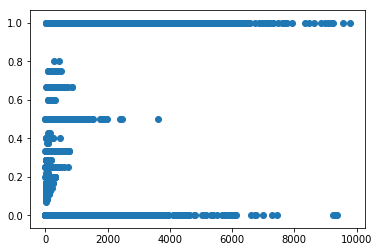

In [33]:
x = []
y = []
for f, ctr in fCTRs.items():
    x.append(f)
    y.append(ctr)
plt.scatter(x,y)

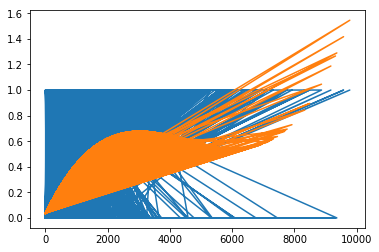

In [47]:
x = train.floorPrice
a1, a2, a3, b = np.polyfit(x, train.isClick, 3)
fh = a1 * x**3 + a2 * x**2 + a3 * x + b
plt.plot(x, train.isClick,  label="f")
plt.plot(x, fh, label="fh")